<a href="https://colab.research.google.com/github/Heity94/WalkieLookie/blob/main/notebooks/PH_Route_within_timeframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install requirements { display-mode: "form" }
#!pip install osmnx
#!pip install networkx
#!pip install geopy

❗**Attention**: In order to make the code work you need to **restart your runtime** afer executing the cell above ☝ (not just reloading the web page).<br> 
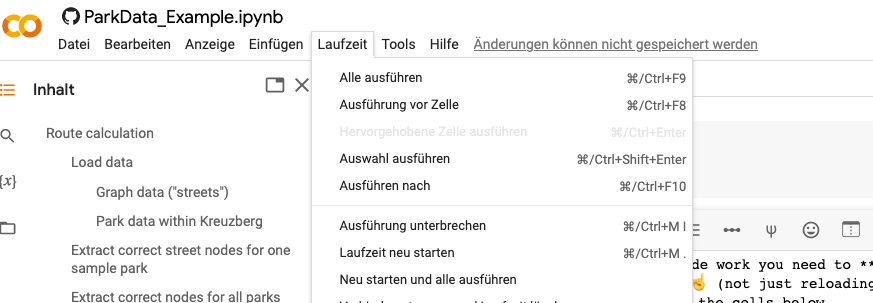
<br>
After that you can continue with running the cells below 

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
#@title Imports
import pickle
import folium
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
ox.config(log_console=True, use_cache=True)
from geopy.geocoders import Nominatim
from networkx.algorithms import approximation as approx # Greedy salesman algorithms
import sklearn
from ast import literal_eval

/home/valentin_werner/Philipps_Playground/philipps_venv/lib/python3.8/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [2]:
# Link to common google drive folder (you have to add a link from the foder to your drive first)
#data_path = "/content/drive/MyDrive/BPI Lap WalkieLookie/Data/"
#data_path = "/content/drive/MyDrive/WalkieLookie/BPI Lap WalkieLookie/Data" #Roger
data_path="/home/valentin_werner/Philipps_Playground/WalkieLookie/data/"

# Preprocess Berlin park nodes

In [3]:
bln_xberg_wo_NaN = pd.read_csv(data_path+"/bln_xberg_parks_nodes_wo_NaN.csv", index_col=0)

In [4]:
bln_xberg_wo_NaN.head(1)

,osmid,name,nodes_within_park
0,4638994.0,Viktoriapark,"[7086354702, 7086354703, 7086354704, 708635470..."


In [5]:
#load stored graph pickle file
with open(data_path+'graph_bln_kzb.obj', 'rb') as fp:
  graph_bln_kzb = pickle.load(fp)

In [6]:
from ast import literal_eval

#Change type to list
bln_xberg_wo_NaN["nodes_within_park"]=bln_xberg_wo_NaN.nodes_within_park.apply(lambda x: literal_eval(x))

In [7]:
# Store nodes of Berlin Graph (Streets) -> storage as set is way fatser than lists!!!!
gr_bln = set(graph_bln_kzb.nodes())

In [8]:
%%time
# Create column whihc only includes nodes which are also within the berlin graph dats (streets)
bln_xberg_wo_NaN["park_nodes_within_graph"] = bln_xberg_wo_NaN.nodes_within_park.apply(lambda x: [node for node in x if node in gr_bln])

CPU times: user 3.05 ms, sys: 0 ns, total: 3.05 ms
Wall time: 3 ms


In [9]:
bln_xberg_wo_NaN.head(3)

,osmid,name,nodes_within_park,park_nodes_within_graph
0,4638994.0,Viktoriapark,"[7086354702, 7086354703, 7086354704, 708635470...","[241490617, 401579047, 2022056010, 1977632074,..."
1,12773361.0,NaN,"[710862331, 3411068721, 9582743421, 710862332,...","[710862331, 3411068721, 9582743421, 710862332,..."
2,13853629.0,Körnerpark,"[9311122713, 9238292155, 1455122375, 145512220...",[]


In [10]:
# Check length of list of park_nodes_within_graph
bln_xberg_wo_NaN.park_nodes_within_graph.apply(lambda x: len(x)).sort_values()

70       0
36       0
37       0
97       0
92       0
      ... 
40     114
137    138
114    203
3      285
0      333
Name: park_nodes_within_graph, Length: 133, dtype: int64

Some parks (very small ones) do not have streets in them. We have to filter out these "empty rows"

In [11]:
# Remove rows which have a length of 0
bln_xberg_wo_NaN_cln = bln_xberg_wo_NaN[bln_xberg_wo_NaN.park_nodes_within_graph.apply(lambda x: len(x)) > 0].copy()

In [12]:
# Function to calculate center node (if possible), otherwise retunr "No center found"
def center_nodes(x):
  try: 
    return nx.center(graph_bln_kzb.subgraph(x))[0] #take first center node (in case there are more than 1)
  except:
    return "No center found"

In [13]:
# Get center node for each park
bln_xberg_wo_NaN_cln["center_node"] = bln_xberg_wo_NaN_cln.park_nodes_within_graph.apply(lambda x: center_nodes(x))

In [14]:
bln_xberg_wo_NaN_cln.head(3)

,osmid,name,nodes_within_park,park_nodes_within_graph,center_node
0,4638994.0,Viktoriapark,"[7086354702, 7086354703, 7086354704, 708635470...","[241490617, 401579047, 2022056010, 1977632074,...",330288907
1,12773361.0,NaN,"[710862331, 3411068721, 9582743421, 710862332,...","[710862331, 3411068721, 9582743421, 710862332,...",3411068721
3,15740772.0,Görlitzer Park,"[5630371451, 5630371452, 5630371453, 563037145...","[122087881, 32248759, 157467514, 5630372655, 6...",383277458


In [15]:
# For 10 parks there could not be a center found
bln_xberg_wo_NaN_cln.center_node.value_counts().head(2)

No center found    8
791390982          3
Name: center_node, dtype: int64

In [16]:
# Store file as .csv
#bln_xberg_wo_NaN_cln.to_csv(data_path+"bln_xberg_parks_nodes_wo_NaN_with_center.csv")

# Create route which fits within user timeframe

In [17]:
# filter out parks without center (for now)
bln_xberg_wo_NaN_cln = bln_xberg_wo_NaN_cln[bln_xberg_wo_NaN_cln.center_node!="No center found"].copy()

In [18]:
#select three parks
prks_sample = bln_xberg_wo_NaN_cln[bln_xberg_wo_NaN_cln.osmid.isin([1065171552.0, 4638994.0, 45115505.0])]

In [19]:
# Select center park nodes
parks_to_visit = prks_sample.loc[:,"center_node"].to_list()

In [20]:
# find shortest path based on distance or time
optimizer = 'length'        # 'length','time'

#  find the shortest path
shortest_route = nx.shortest_path(graph_bln_kzb,
                                  parks_to_visit[0],
                                  parks_to_visit[1],
                                  weight=optimizer)

In [21]:
#plot combined route
ox.plot_route_folium(graph_bln_kzb, shortest_route)

Using the traveling salesman problem function on the complete graph data of Berlin Kreuzberg the code runs forever until it eventually kills my notebook because of RAM???

In [70]:
#%%time
#TSM_path = approx.traveling_salesman_problem(graph_bln_kzb, nodes=parks_to_visit, weight="length", cycle=False)#, method=method, weight="length")

Lets try out if a smaller graph solves the problem

In [71]:
# Download smaller graph which hardly contains the three parks
test_graph = ox.graph.graph_from_address("Zossener Straße 11, 10961 Berlin", dist=1000, network_type='walk')
#with open('/content/drive/MyDrive/graph_berlin_kzb_small.obj', 'wb') as fp:
#  pickle.dump(test_graph, fp)

#load stored graph pickle file
#with open('/content/drive/MyDrive/graph_berlin_kzb_small.obj', 'rb') as fp:
#  test_graph = pickle.load(fp)


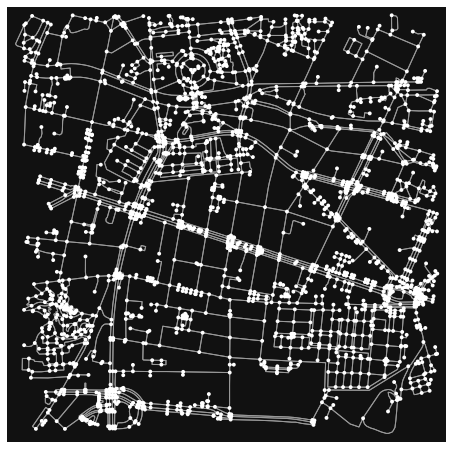

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [72]:
# Lets plot the map
ox.plot_graph(test_graph)

In [73]:
#%%time
#TSM_path = approx.traveling_salesman_problem(test_graph, nodes=parks_to_visit, weight="length", cycle=True)

At least this time it worked, but still it took almost a minute to calculate the route

In [74]:
# Sum up travel time and distance
#cols = ['osmid', 'length']#, 'travel_time']
attrs = ox.utils_graph.get_route_edge_attributes(test_graph, TSM_path)
df_route = pd.DataFrame(attrs)[cols]
print("Total lenght [m]:", df_route.length.sum().round(2))
print("Predicted travel time in minutes for an avg. speed of 5km/h:", round((df_route.length.sum()/5000)*60))

NameError: name 'TSM_path' is not defined

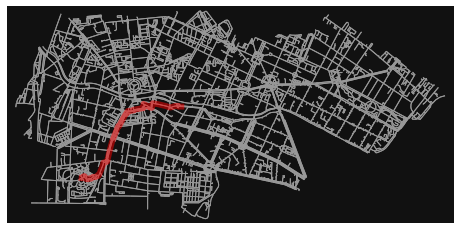

In [ ]:
#plot route on the berlin kreuzberg full map
ox.plot_graph_route(graph_bln_kzb, TSM_path, route_color="red", route_linewidth=6, node_size=0, orig_dest_size=0);

In [35]:
#Plot route whch passes by all parks with folium
TSM_map = ox.plot_route_folium(graph_bln_kzb, TSM_path)

# Add markers of parks
for i, park in enumerate(parks_to_visit):
  latlng_parks = (graph_bln_kzb.nodes()[park]["y"], graph_bln_kzb.nodes()[park]["x"])
  marker = folium.Marker(
              location = latlng_parks,
              icon = folium.Icon(color='green'))

  marker.add_to(TSM_map)
TSM_map

# Create own Traveling Salesman Function

If we do not manage to get the algorithm working on a bigger graph (like Kreuzberg or all streets within the ring, we would probably need to download a smaller version of the graph based on the user start location and some radius (based on time). This of course would also slow down our proces quiet a bit ....

In [8]:
def get_searchradius(user_time, avg_speed=5, round_trip=True): 
  '''Calculate search radius for parks and graphs based on the user time and average speed'''

  radius = (avg_speed*1000/60)*user_time

  if round_trip==True:
    radius/2 #half the search radius if person has to go back to same place

  return radius

In [9]:
def load_street_graph(start_address, radius, end_address=None):

  street_graph = ox.graph.graph_from_address(start_address, dist=radius, network_type='walk')
  
  return street_graph

In [10]:
# Function to calculate center node (if possible), otherwise retunr "No center found"
def center_nodes(street_graph, places_nodes_on_map):
  try: 
    return nx.center(street_graph.subgraph(places_nodes_on_map))[0] #take first center node (in case there are more than 1)
  except:
    return "No center found"

In [11]:
from ast import literal_eval

#Load DataFrame with nodes of interest (NOI)
#places_noi = pd.read_csv(data_path+"bln_xberg_parks_nodes_wo_NaN.csv", index_col=0)
#places_noi["nodes_within_park"]=places_noi.nodes_within_park.apply(lambda x: literal_eval(x)) #Change type to list

def get_noi(street_graph, places_noi):

  street_nodes = set(street_graph.nodes())

  # Create column whihc only includes nodes which are also within the berlin graph dats (streets)
  places_noi["park_nodes_within_graph"] = places_noi.nodes_within_park.apply(lambda x: [node for node in x if node in street_graph])

  places_noi = places_noi[places_noi.park_nodes_within_graph.apply(lambda x: len(x)) > 0].copy() #Filter out empty parks

  # Get center node for each park
  places_noi["center_node"] = places_noi.park_nodes_within_graph.apply(lambda x: center_nodes(street_graph, x))

  # filter out parks without center (for now)
  places_noi = places_noi[places_noi.center_node!="No center found"].copy()

  # Select center park nodes and store as list for route planning
  nodes_to_visit = places_noi.loc[:,"center_node"].to_list()

  return places_noi, nodes_to_visit

In [12]:
def add_start_end_node(start_address, street_graph, nodes_to_visit, end_address=None):
  '''Add start (and end address) to list of nodes which should be visited'''

  locator = Nominatim(user_agent = "myapp")

  # stores the start and end points as geopy.point.Point objects
  start_latlng = locator.geocode(start_address).point
  #end_latlng = locator.geocode(end_location).point

  orig_node = ox.distance.nearest_nodes(street_graph, start_latlng[1], start_latlng[0]) #graph, long, lat

  nodes_to_visit = [orig_node]+nodes_to_visit #add start node tto list to visit

  return nodes_to_visit

In [13]:
def caculate_route(street_graph, nodes_to_visit, cycle=True):

  calc_route = approx.traveling_salesman_problem(street_graph, nodes=nodes_to_visit, cycle=cycle)#, weight="length")

  return calc_route

In [14]:
def get_route_stats(calc_route, street_graph):
  '''Get total length and travel time of calculated route'''
    
  # Sum up travel time and distance
  cols = ['osmid', 'length']#, 'travel_time']
  attrs = ox.utils_graph.get_route_edge_attributes(street_graph, calc_route)
  df_route = pd.DataFrame(attrs)[cols]
  
  length_m = df_route.length.sum().round().astype("int")
  travel_time_min = round((df_route.length.sum()/5000)*60)

  return length_m, travel_time_min

### Try out functions

In [86]:
# User inut
user_time = 10 #minutes
start_address = "Zossener Straße 11, 10961 Berlin"
round_trip=True
avg_speed =5 

In [87]:
#Load DataFrame with nodes of interest (NOI)
places_noi = pd.read_csv(data_path+"bln_xberg_parks_nodes_wo_NaN.csv", index_col=0)
places_noi["nodes_within_park"]=places_noi.nodes_within_park.apply(lambda x: literal_eval(x)) #Change type to list

In [88]:
# Let all functions run
radius = get_searchradius(user_time, avg_speed, round_trip)
street_graph = load_street_graph(start_address, radius)
places_noi, nodes_to_visit = get_noi(street_graph, places_noi)
nodes_to_visit_final = add_start_end_node(start_address, street_graph, nodes_to_visit)

In [89]:
#street_graph_tst = ox.distance.add_edge_lengths(street_graph)

In [110]:
optimizer = "time"

# given on time: take the starting address and x number of nodes from list 
x = int(user_time/5) #one place of interest for each 5 minutes
if x>len(nodes_to_visit_final[1:]): # if number of theoretical nodes to visit is higher than the points of interest in the list take lenght of list
    x = len(nodes_to_visit_final[1:])

start_node = nodes_to_visit_final[0] #extract start node

#notes_to_visit_small = np.random.choice(nodes_to_visit_final[1:], x, replace=False).tolist() #sample

#instead of random sampling of nodes to visit we calculate the distance from the start address and order the list accordingly and then slice it 
tmp_dict={}

for node in nodes_to_visit_final[1:]:
    
    shortest_route = nx.shortest_path(street_graph,
                                start_node,
                                node,
                                weight=optimizer)

    #Calculate route statistics for each node
    length_m, travel_time_min = get_route_stats(shortest_route, street_graph)
    
    # Add route and stats to tmp_dict
    tmp_dict[node]={"shortest_path": shortest_route,
                    "length_m": length_m,
                    "travel_time_min": travel_time_min}

# select shortest path and append to final path list
df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index").sort_values(by=["travel_time_min"], ascending=True)
notes_to_visit_sorted = df_tmp.index.to_list()
notes_to_visit_small = notes_to_visit_sorted[:x]


final_path = [] #list to store all the final paths

iterrations = len(notes_to_visit_small) # number of times we heave to run a for loop

for i in range(iterrations):

    # from the starting address calculate shortest path to all other nodes and store distance in list
    tmp_dict={}

    for node in notes_to_visit_small:
        
        shortest_route = nx.shortest_path(street_graph,
                                    start_node,
                                    node,
                                    weight=optimizer)

        #Calculate route statistics for each node
        length_m, travel_time_min = get_route_stats(shortest_route, street_graph)
        
        # Add route and stats to tmp_dict
        tmp_dict[node]={"shortest_path": shortest_route,
                        "length_m": length_m,
                        "travel_time_min": travel_time_min}

    # select shortest path and append to final path list
    df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index")
    node_sh_path_overall = df_tmp.travel_time_min.idxmin()
    shortest_path_overall = df_tmp.loc[node_sh_path_overall, "shortest_path"]
    final_path.append(shortest_path_overall[:-1]) #add all nodes except the last (because the start of next will start at same route)

    start_node = notes_to_visit_small.pop(notes_to_visit_small.index(node_sh_path_overall)) #remove new start node from list and set as new start point for next iterration

#If it is a round trip add one more path from last point to start address to list
if round_trip==True:

    shortest_route = nx.shortest_path(street_graph,
                            start_node,
                            nodes_to_visit_final[0],
                            weight=optimizer)

    final_path.append(shortest_route)


final_path_flat = [x for xs in final_path for x in xs]

#Calculate route statistics for each node
length_m, travel_time_min = get_route_stats(final_path_flat, street_graph)


Let's turn this part into a function

In [37]:
# User inut
user_time = 10 #minutes
start_address = "Zossener Straße 11, 10961 Berlin"
round_trip=True
avg_speed =5 
time_margin = 10
optimizer = "time"

In [16]:
#Load DataFrame with nodes of interest (NOI)
places_noi = pd.read_csv(data_path+"bln_xberg_parks_nodes_wo_NaN.csv", index_col=0)
places_noi["nodes_within_park"]=places_noi.nodes_within_park.apply(lambda x: literal_eval(x)) #Change type to list

In [17]:
# Let all functions run
radius = get_searchradius(user_time, avg_speed, round_trip)
street_graph = load_street_graph(start_address, radius)
places_noi, nodes_to_visit = get_noi(street_graph, places_noi)
nodes_to_visit_final = add_start_end_node(start_address, street_graph, nodes_to_visit)

In [23]:
def inital_nodes_to_consider(user_time, nodes_to_visit_final, street_graph, optimizer="time"):

    # given on time: take the starting address and x number of nodes from list 
    x = int(user_time/5) #one place of interest for each 5 minutes
    if x>len(nodes_to_visit_final[1:]): # if number of theoretical nodes to visit is higher than the points of interest in the list take lenght of list
        x = len(nodes_to_visit_final[1:])

    start_node = nodes_to_visit_final[0] #extract start node

    #notes_to_visit_small = np.random.choice(nodes_to_visit_final[1:], x, replace=False).tolist() #sample

    #instead of random sampling of nodes to visit we calculate the distance from the start address and order the list accordingly and then slice it 
    tmp_dict={}

    for node in nodes_to_visit_final[1:]:
        
        shortest_route = nx.shortest_path(street_graph,
                                    start_node,
                                    node,
                                    weight=optimizer)

        #Calculate route statistics for each node
        length_m, travel_time_min = get_route_stats(shortest_route, street_graph)
        
        # Add route and stats to tmp_dict
        tmp_dict[node]={"shortest_path": shortest_route,
                        "length_m": length_m,
                        "travel_time_min": travel_time_min}

    # select shortest path and append to final path list
    df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index").sort_values(by=["travel_time_min"], ascending=True)
    notes_to_visit_sorted = df_tmp.index.to_list()
    
    notes_to_visit_small = notes_to_visit_sorted[:x]

    return notes_to_visit_small, notes_to_visit_sorted, x, start_node


In [19]:
def create_walking_route(street_graph,  start_node, notes_to_visit_small, round_trip):

    final_path = [] #list to store all the final paths

    iterrations = len(notes_to_visit_small) # number of times we heave to run a for loop

    for i in range(iterrations):

        # from the starting address calculate shortest path to all other nodes and store distance in list
        tmp_dict={}

        for node in notes_to_visit_small:
            
            shortest_route = nx.shortest_path(street_graph,
                                        start_node,
                                        node,
                                        weight=optimizer)

            #Calculate route statistics for each node
            length_m, travel_time_min = get_route_stats(shortest_route, street_graph)
            
            # Add route and stats to tmp_dict
            tmp_dict[node]={"shortest_path": shortest_route,
                            "length_m": length_m,
                            "travel_time_min": travel_time_min}

        # select shortest path and append to final path list
        df_tmp = pd.DataFrame.from_dict(tmp_dict, orient="index")
        node_sh_path_overall = df_tmp.travel_time_min.idxmin()
        shortest_path_overall = df_tmp.loc[node_sh_path_overall, "shortest_path"]
        final_path.append(shortest_path_overall[:-1]) #add all nodes except the last (because the start of next will start at same route)

        start_node = notes_to_visit_small.pop(notes_to_visit_small.index(node_sh_path_overall)) #remove new start node from list and set as new start point for next iterration

    #If it is a round trip add one more path from last point to start address to list
    if round_trip==True:

        shortest_route = nx.shortest_path(street_graph,
                                start_node,
                                nodes_to_visit_final[0],
                                weight=optimizer)

        final_path.append(shortest_route)


    final_path_flat = [x for xs in final_path for x in xs]

    #Calculate route statistics for each node
    length_m, travel_time_min = get_route_stats(final_path_flat, street_graph)

    return final_path_flat, length_m, travel_time_min

In [50]:
def evaluate_iterrate_route(final_path_flat, length_m, travel_time_min, notes_to_visit_sorted, x, start_node, user_time, street_graph, round_trip, time_margin=10):

    x_init = None

    #Check if travel time is in between +-10 minutes from user time -> if yes return route
    while not ((travel_time_min<=user_time+time_margin) & (travel_time_min>=user_time-time_margin))|(x_init==x):
        
        #save inital x
        x_init = x

        #Check if travel time much smaller than the user time -> if yes add more route points
        if (travel_time_min<(user_time+time_margin)):
            x+= 1 #(user_time-travel_time_min)/5
        elif (travel_time_min>(user_time+time_margin)):
            x-= 1 #(user_time-travel_time_min)/5
        
        #update nodes_to_visist
        notes_to_visit_small = notes_to_visit_sorted[:x]
        final_path_flat, length_m, travel_time_min = create_walking_route(street_graph,start_node,notes_to_visit_small, round_trip=round_trip)


    print("Route found")
    return final_path_flat, length_m, travel_time_min

    

In [24]:
notes_to_visit_small, notes_to_visit_sorted, x, start_node = inital_nodes_to_consider(user_time, nodes_to_visit_final, street_graph, optimizer=optimizer)

In [25]:
final_path_flat, length_m, travel_time_min = create_walking_route(street_graph,  start_node, notes_to_visit_small, round_trip)

In [55]:
user_time = 60 #minutes

In [56]:
final_path_flat, length_m, travel_time_min = evaluate_iterrate_route(final_path_flat, length_m, travel_time_min, notes_to_visit_sorted, x, start_node, user_time, street_graph, round_trip, time_margin)

Route found


In [60]:
print("Route length:", length_m)
print("Estimated Travel time:", travel_time_min)
print("Defined Timeframe from user:", user_time)

Route length: 4450
Estimated Travel time: 53
Defined Timeframe from user: 60


In [61]:
ox.plot_route_folium(street_graph, final_path_flat)